In [1]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import autograd.numpy as np

from plot_tools import plot_contourf, plot_trajectories, plot_cost_function_3d, plot_evolution_charts, plot_cinematics_charts
from matplotlib.animation import FuncAnimation
from optimizers import Optimizer, run_optimizer
from test_optimization_functions import Beale


In [13]:
iterations = 1500
learning_rate = 0.01
cost_f = Beale()

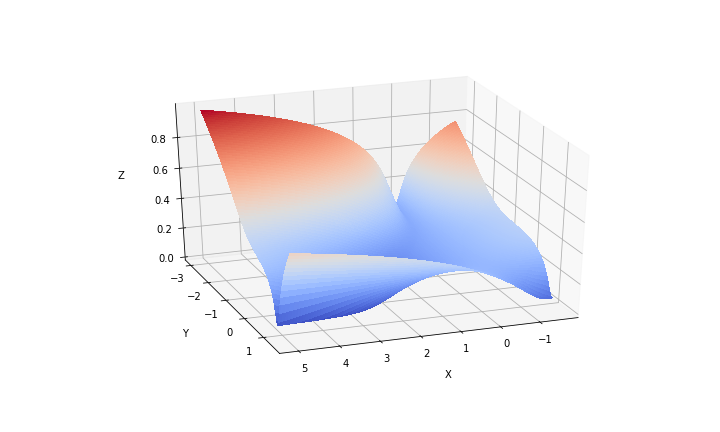

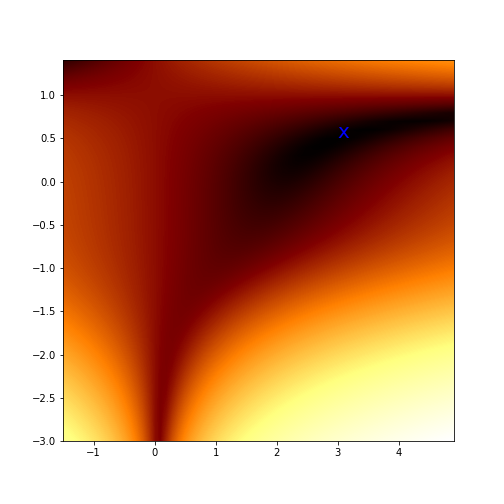

In [3]:
plot_cost_function_3d(cost_f)
plt.show()

plot_contourf(cost_f, figsize=[7, 7])
plt.show()

### SGD

In [26]:
class SGD(Optimizer):
    def __init__(self, cost_f, lr=0.001, x=None, y=None):
        super().__init__(cost_f, lr, x, y)
            
    def step(self, lr = None):
        if not lr:
            lr = self.lr
        f = cost_f.eval(self.x, self.y)
        dx = cost_f.df_dx(self.x, self.y)
        dy = cost_f.df_dy(self.x, self.y)
        self.x = self.x - lr*dx
        self.y = self.y - lr*dy
        return [self.x, self.y]
        

In [27]:

opt = SGD(cost_f=cost_f, lr=learning_rate)

In [28]:
errors_sgd, distance_sgd,\
xs_sgd, ys_sgd = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

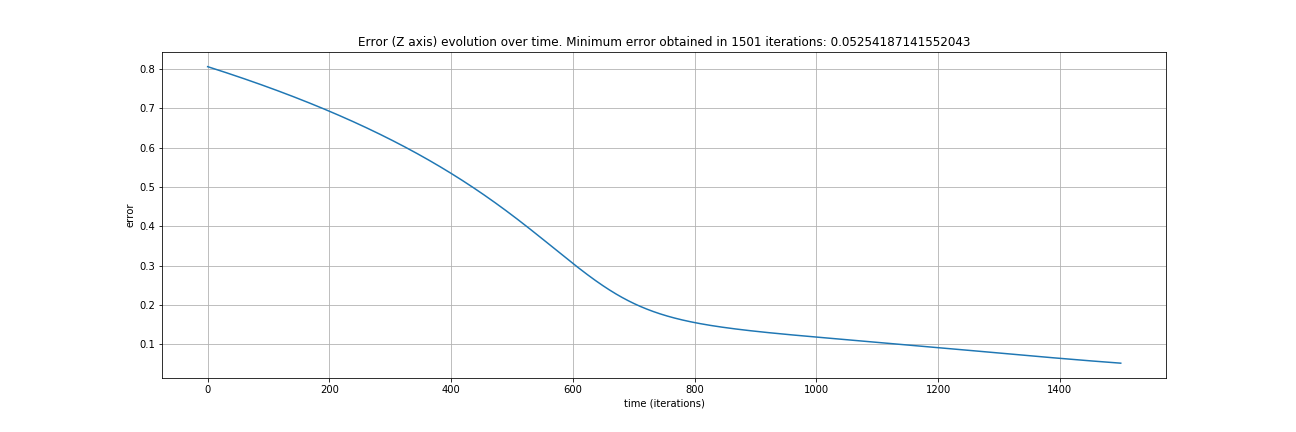

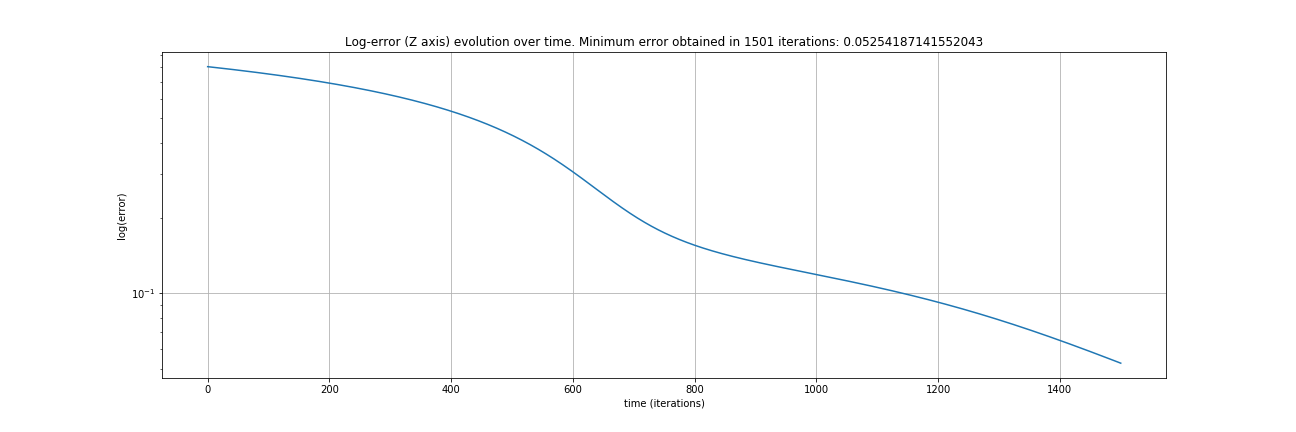

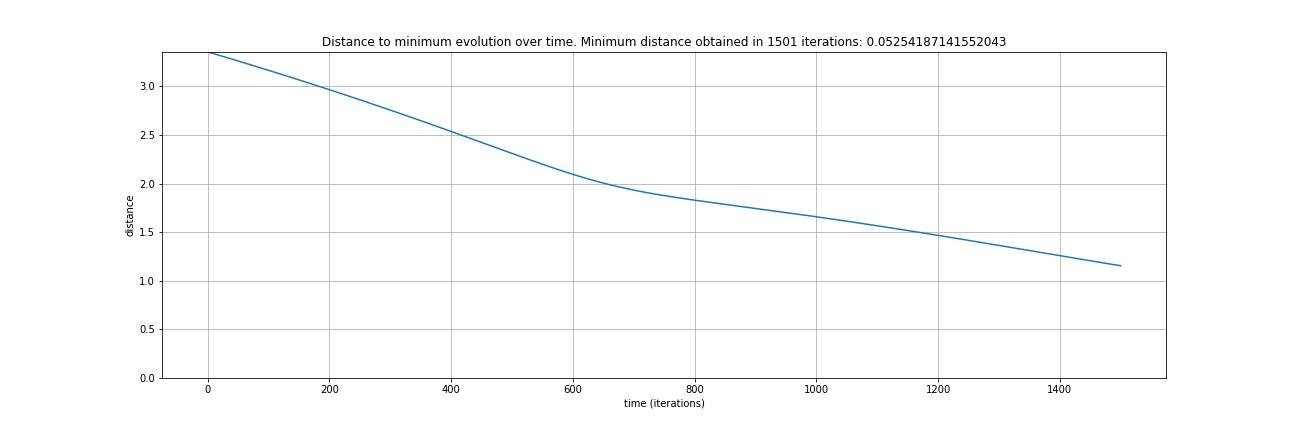

In [29]:
plot_evolution_charts(cost_f, errors_sgd, distance_sgd, xs_sgd, ys_sgd)

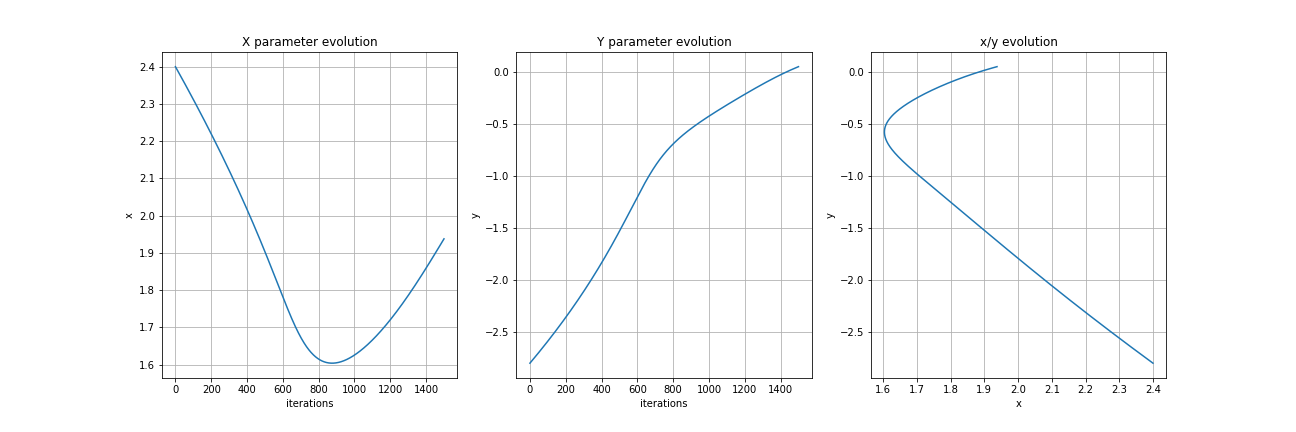

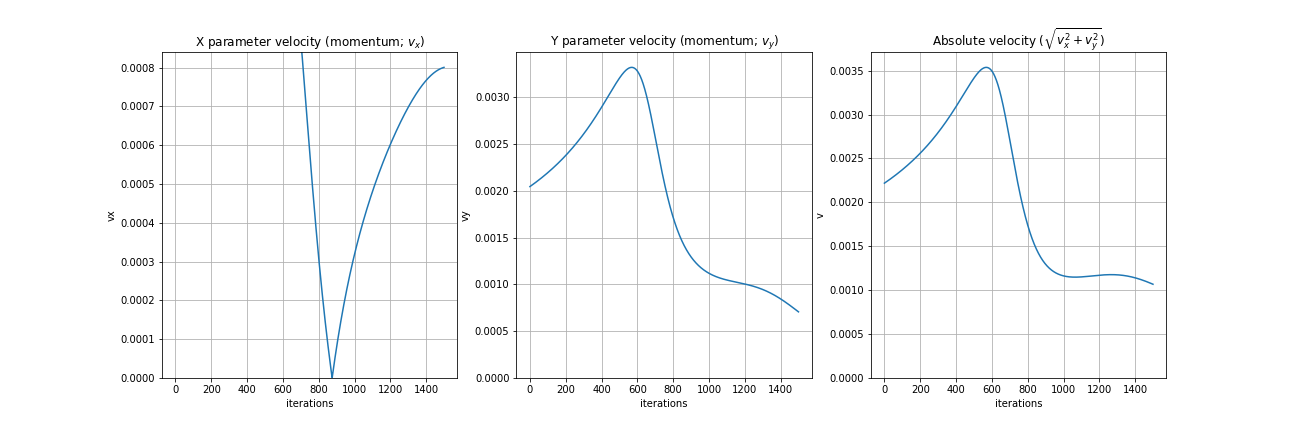

In [30]:
plot_cinematics_charts(xs_sgd, ys_sgd)

### SGD conclusions
##### If slope is small, the optimizzation progression is also small. Thus, for slightly inclined planes the algorithm moves slowly

### SGD with Momentum

In [33]:
class SGD_momentum(Optimizer):
    def __init__(self, cost_f, x=None, y=None, lr=0.001, beta=0.9):
        super().__init__(cost_f=cost_f, x=x, y=y, lr=lr, beta=beta)
        self.vx = 0
        self.vy = 0
        
    def step(self, lr=None, beta=None):
        if lr is None:
            lr = self.lr
        if beta is None:
            beta = self.beta
        f = cost_f.eval(self.x, self.y)
        dx = cost_f.df_dx(self.x, self.y)
        dy = cost_f.df_dy(self.x, self.y)
        
        self.vx = beta * self.vx + lr * dx
        self.vy = beta * self.vy + lr * dy
        
        self.x = self.x - self.vx
        self.y = self.y - self.vy
        
        return [self.x, self.y]

In [34]:
opt = SGD_momentum(cost_f=cost_f, lr=learning_rate, beta=0.9)

In [35]:
errors_momentum, distance_momentum,\
xs_momentum, ys_momentum = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

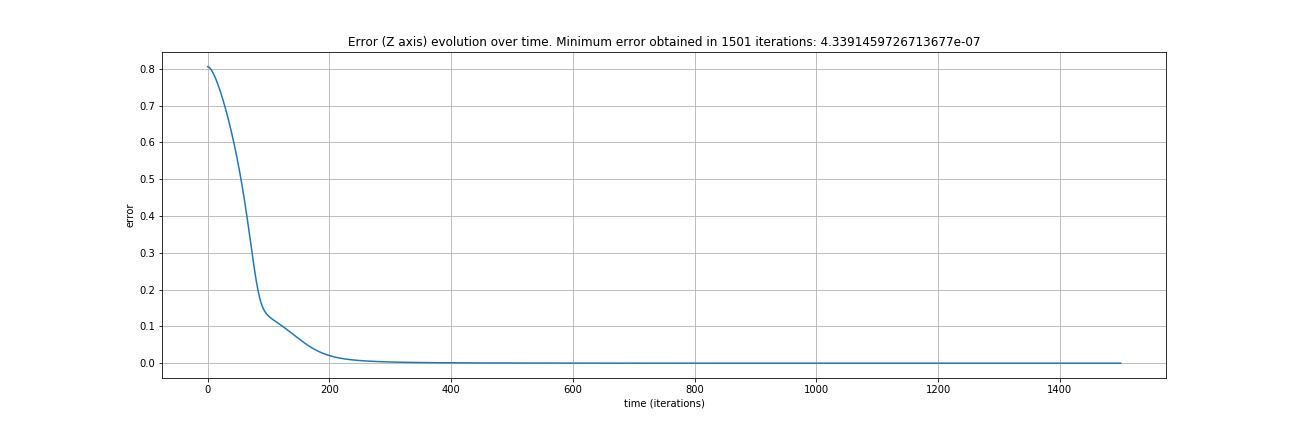

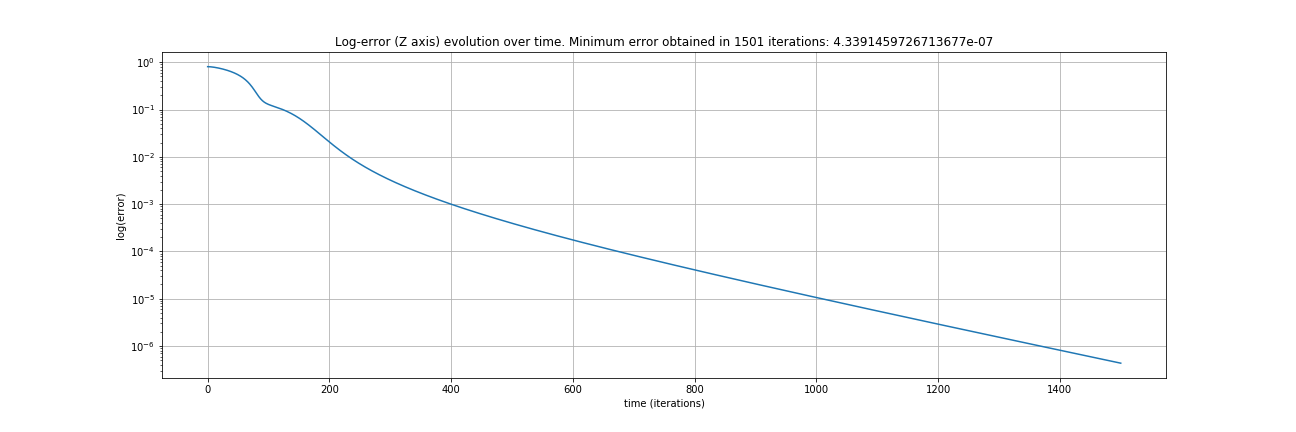

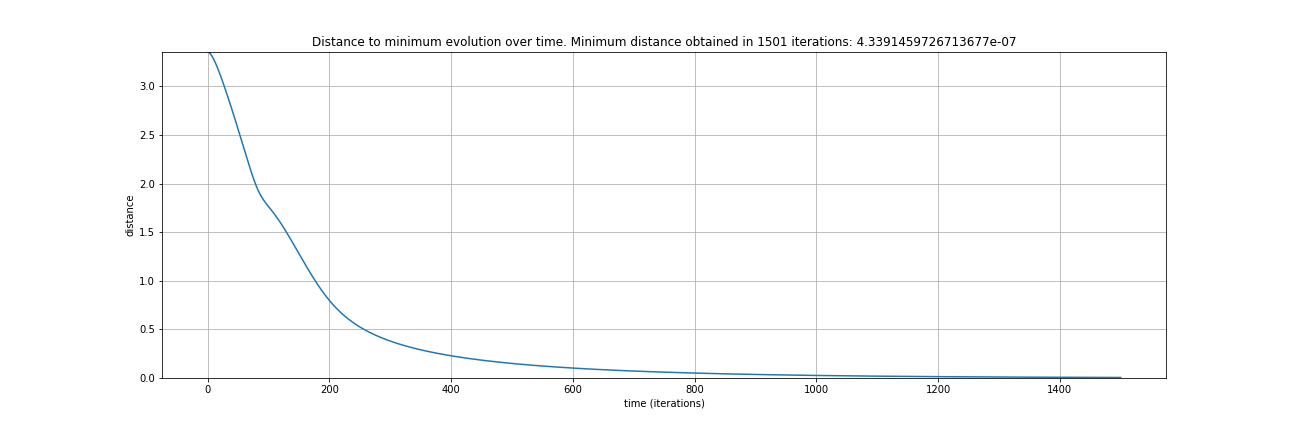

In [36]:
plot_evolution_charts(cost_f, errors_momentum, distance_momentum, xs_momentum, ys_momentum)

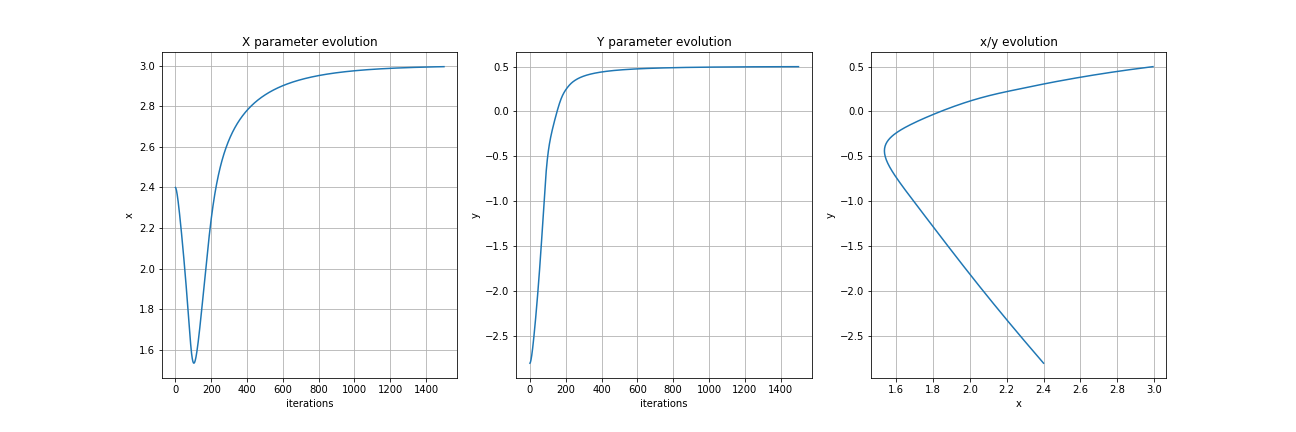

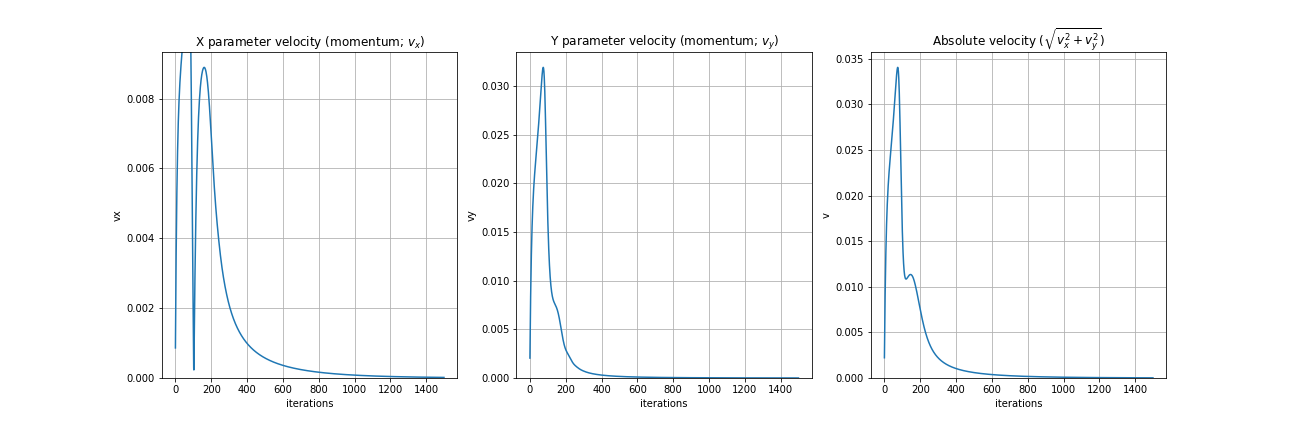

In [37]:
plot_cinematics_charts(xs_momentum, ys_momentum)

### SGD with Momentum - Conclusions
##### Momentum increased progress when slope was very low - thus the convergence was much faster compared to the case with vanilla SGD

### SGD with Nesterov Momentum

#### Case with normal momentum

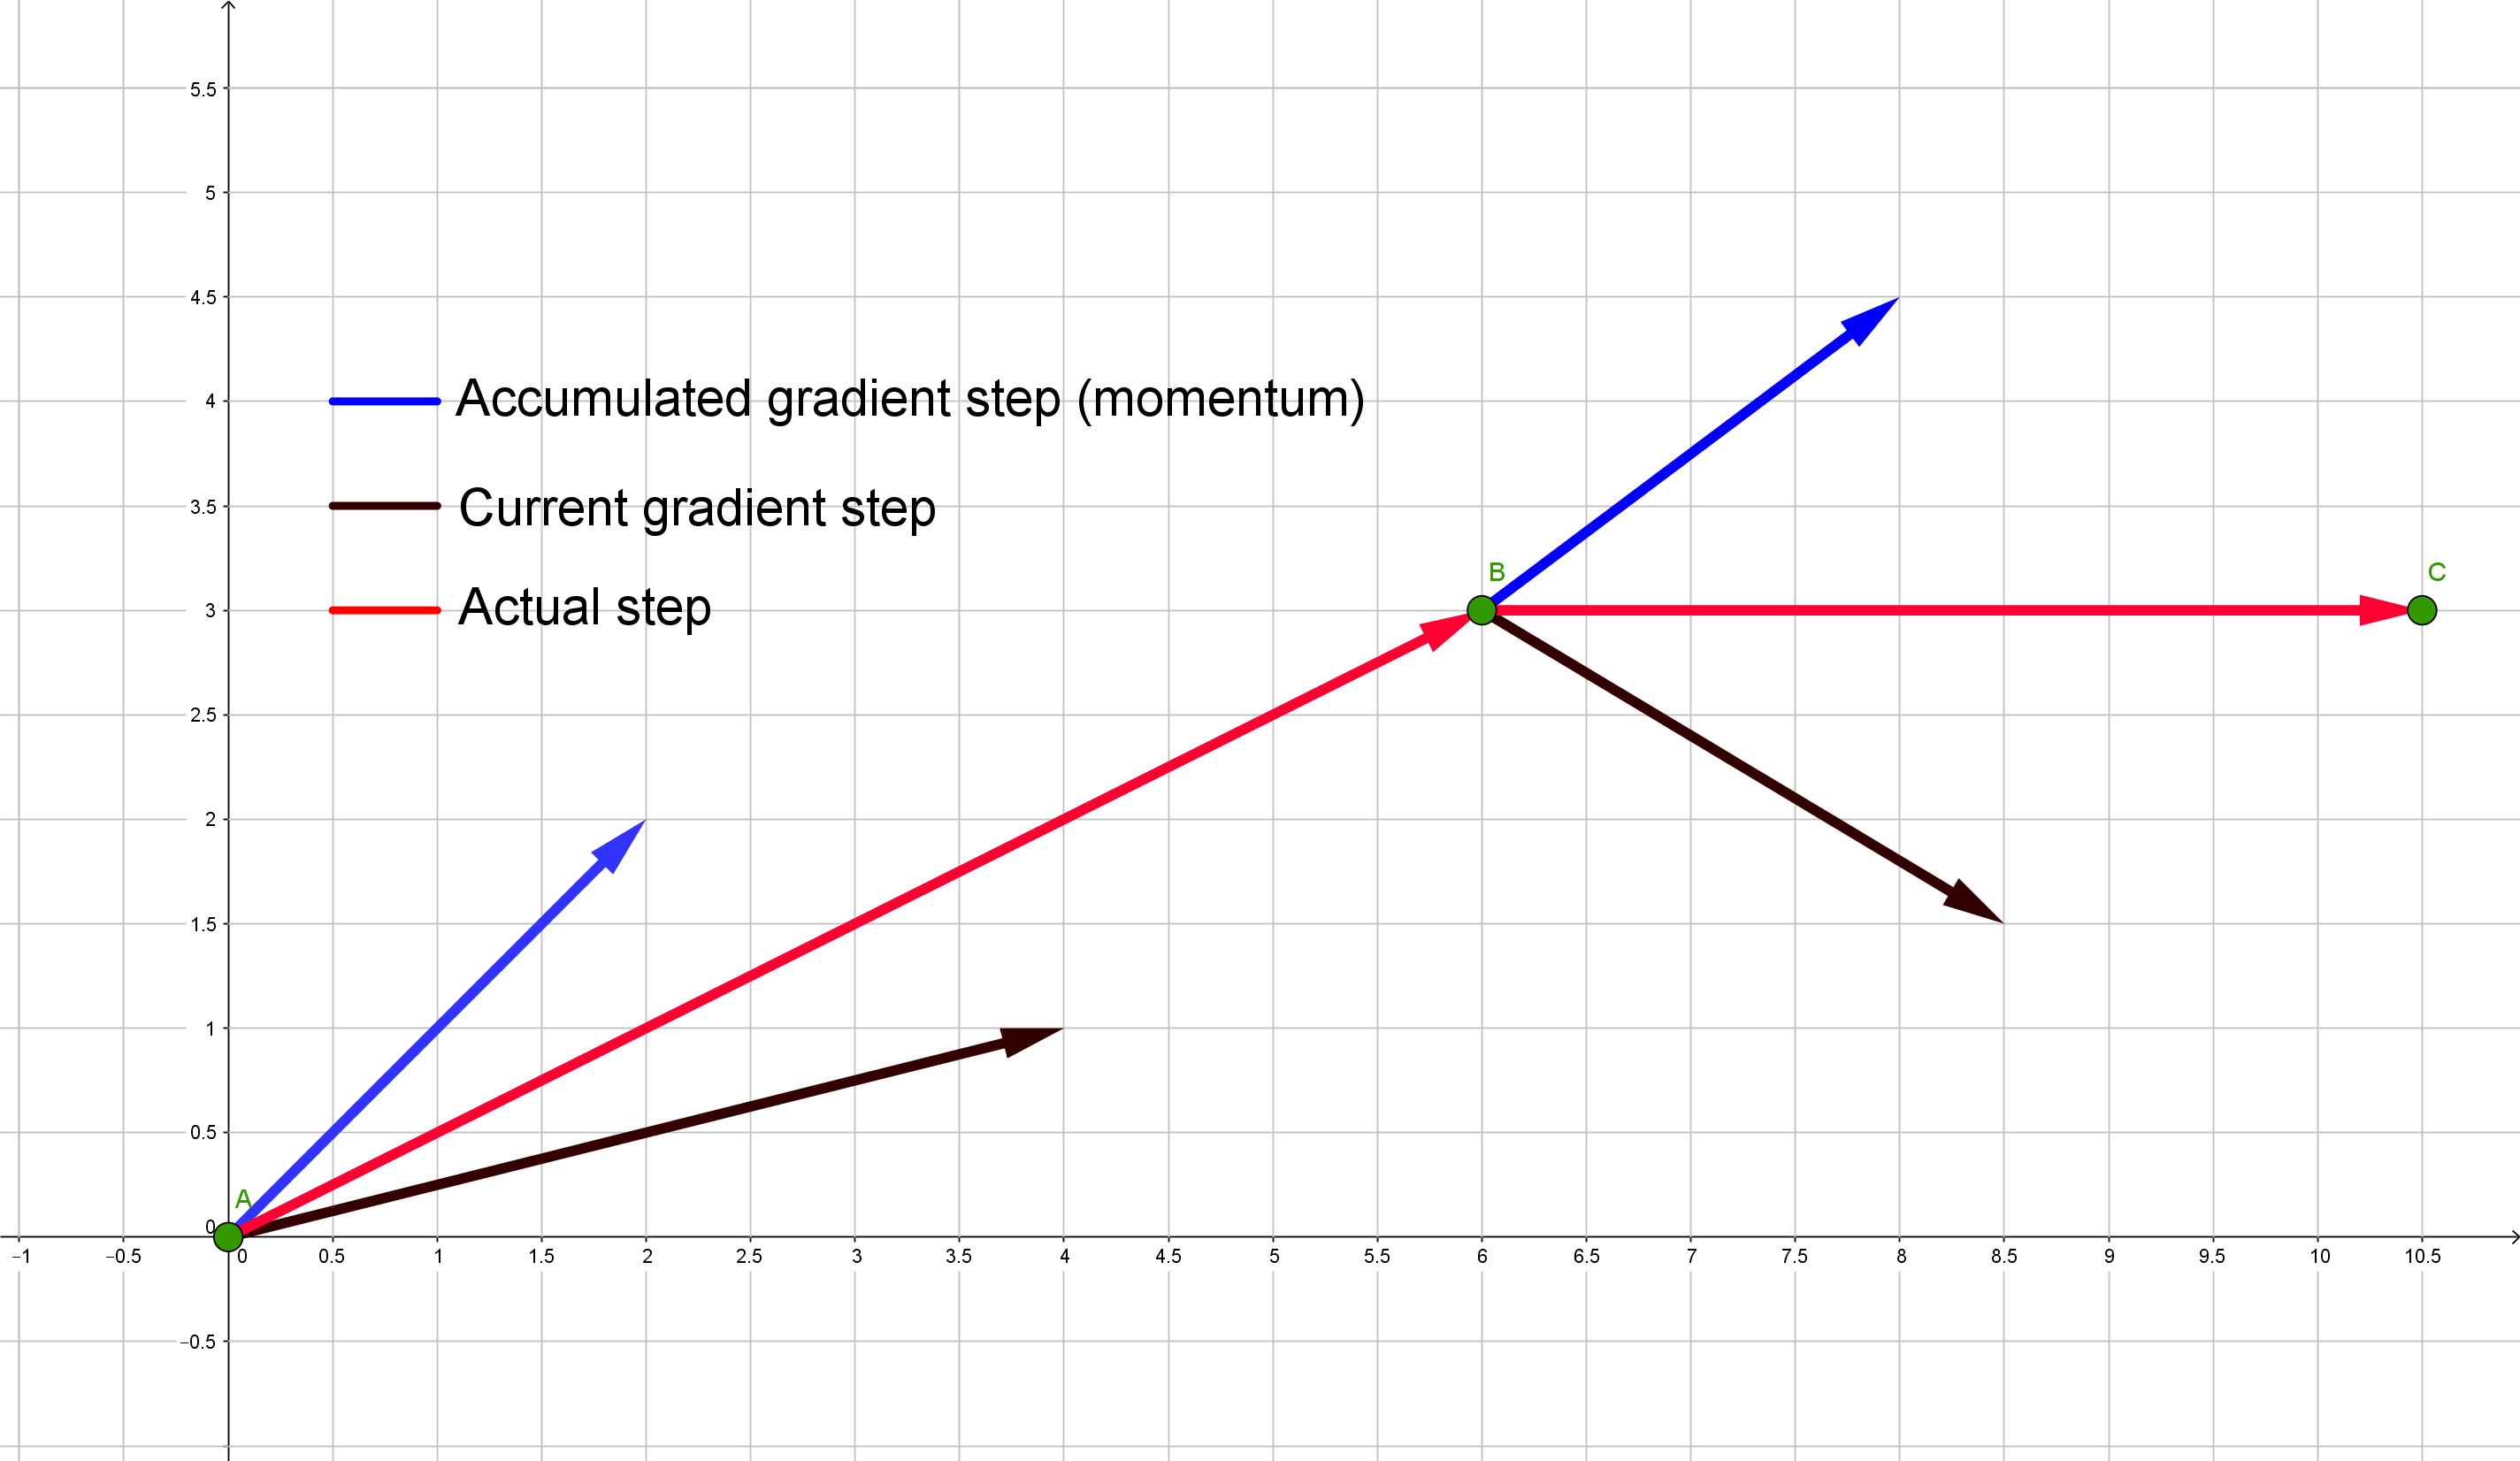

#### Case with Nesterov Momentum

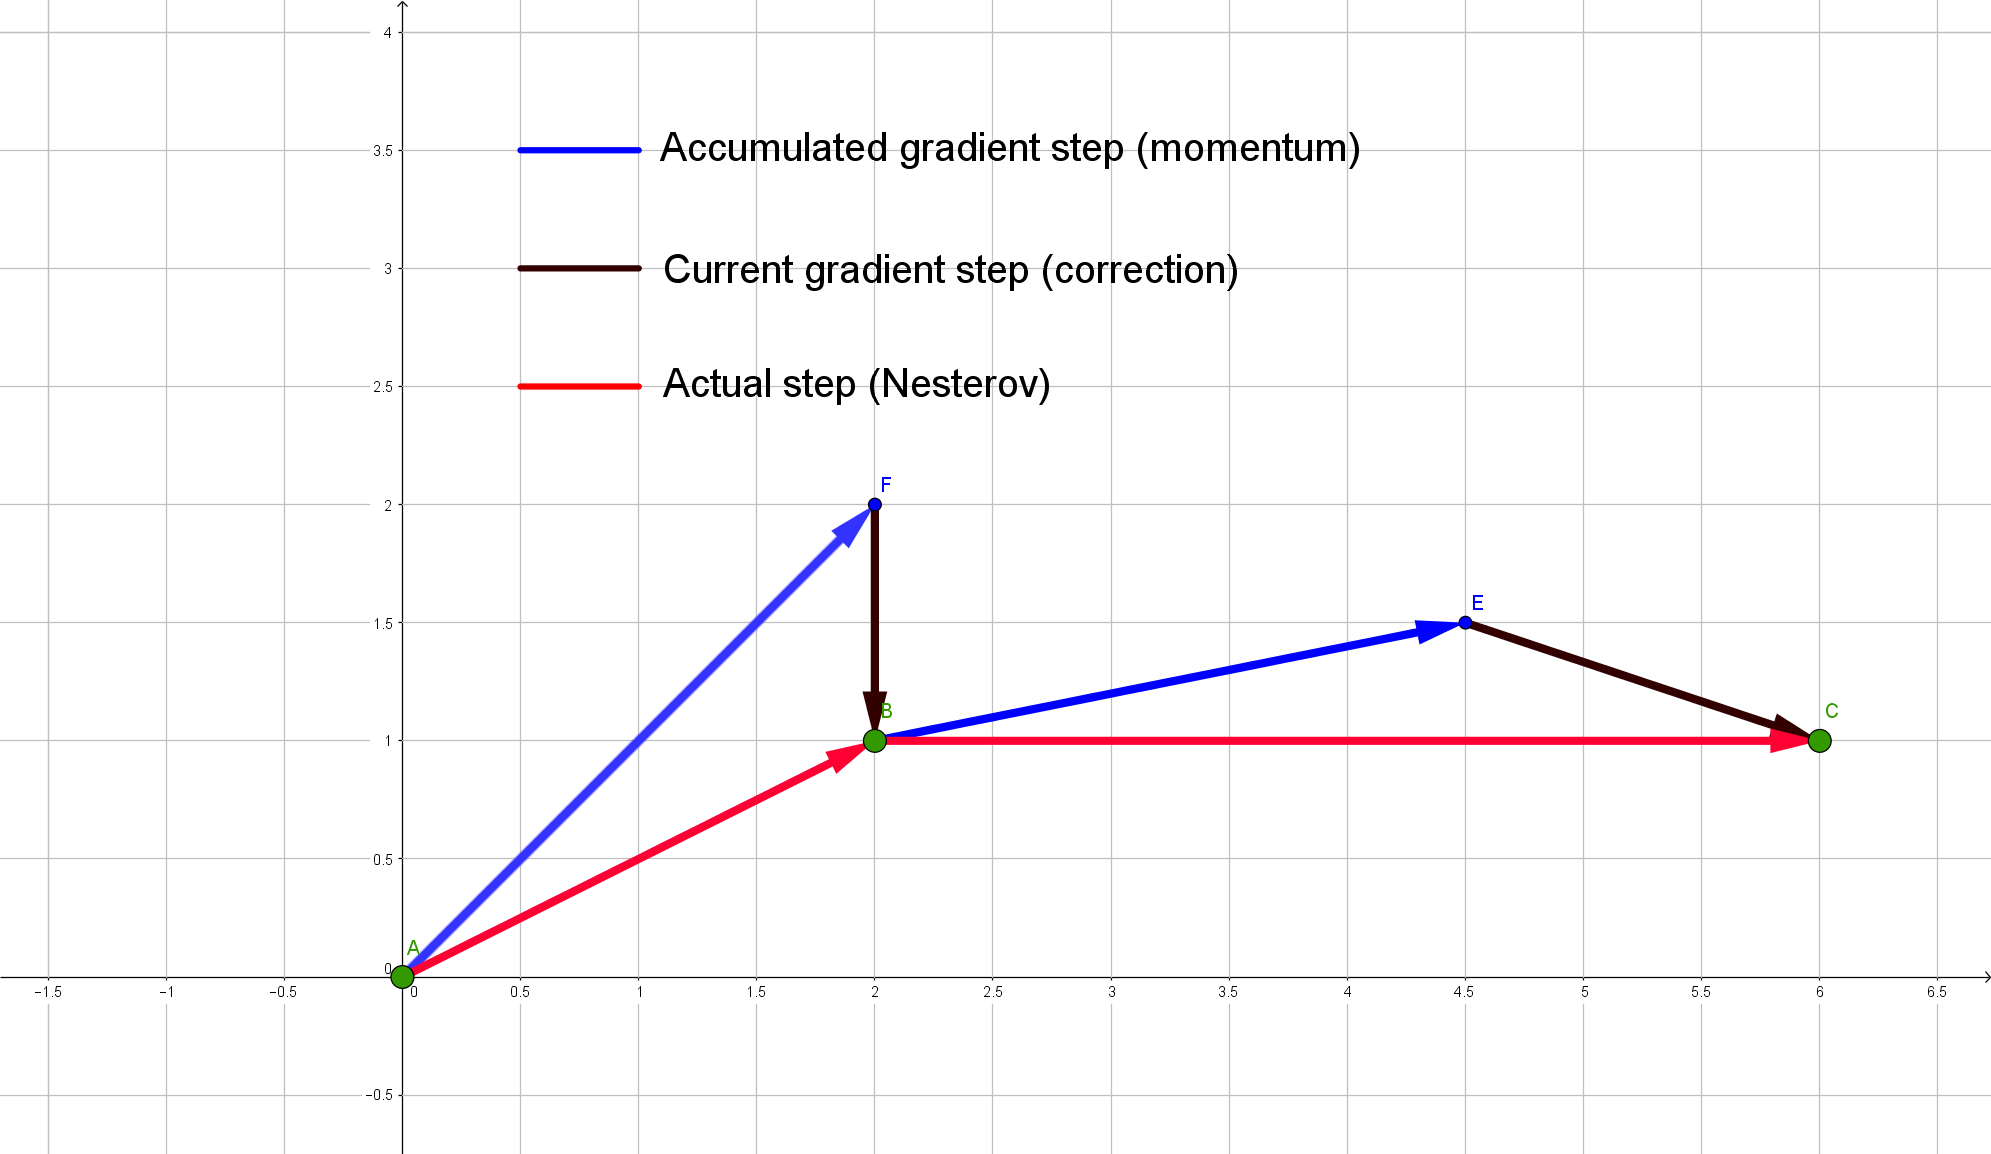

In [16]:
class SGD_Nesterov_momentum(Optimizer):
    
    def __init__(self, cost_f, x=None, y=None, lr=0.001, beta=0.9):
        super().__init__(cost_f=cost_f, x=x, y=y, lr=lr, beta=beta)
        self.vx = None
        self.vy = None
    
    def step(self, beta=None, lr=None):
        
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        
        if beta is None:
            beta = self.beta
        if lr is None:
            lr = self.lr
        if self.vx is None or self.vy is None:
            self.vx = lr * dx
            self.vy = lr * dy
        else:
            dx_in_vx = self.cost_f.df_dx(self.x-beta*self.vx, self.y-beta*self.vy)
            dy_in_vy = self.cost_f.df_dy(self.x-beta*self.vx, self.y-beta*self.vy)
            self.vx = beta * self.vx + lr * dx_in_vx
            self.vy = beta * self.vy + lr * dy_in_vy
        self.x += - self.vx
        self.y += - self.vy
        
        return [self.x, self.y]
        

In [17]:
opt=SGD_Nesterov_momentum(cost_f, lr=learning_rate, beta=0.9)

In [18]:
errors_nesterov, distance_nesterov, xs_nesterov, ys_nesterov = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

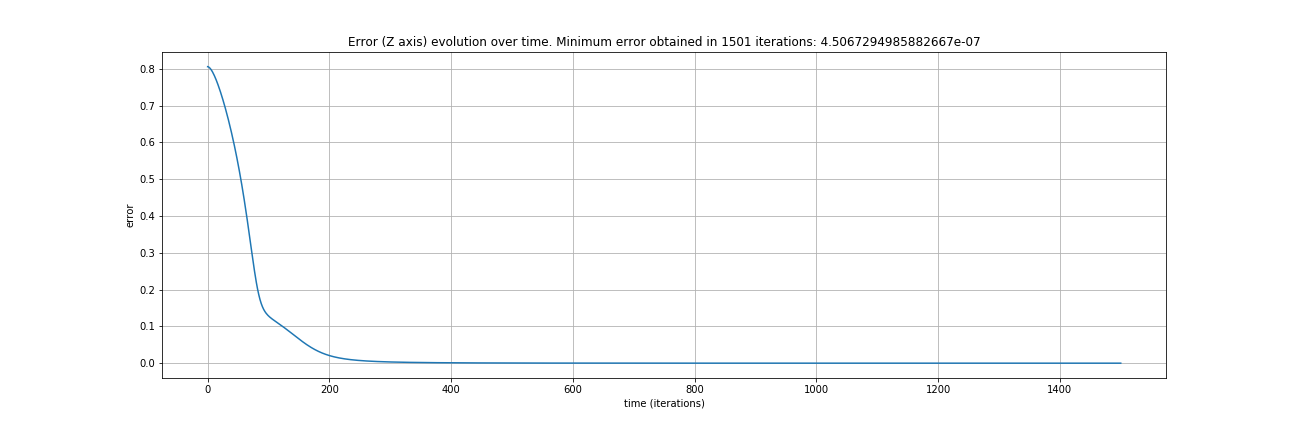

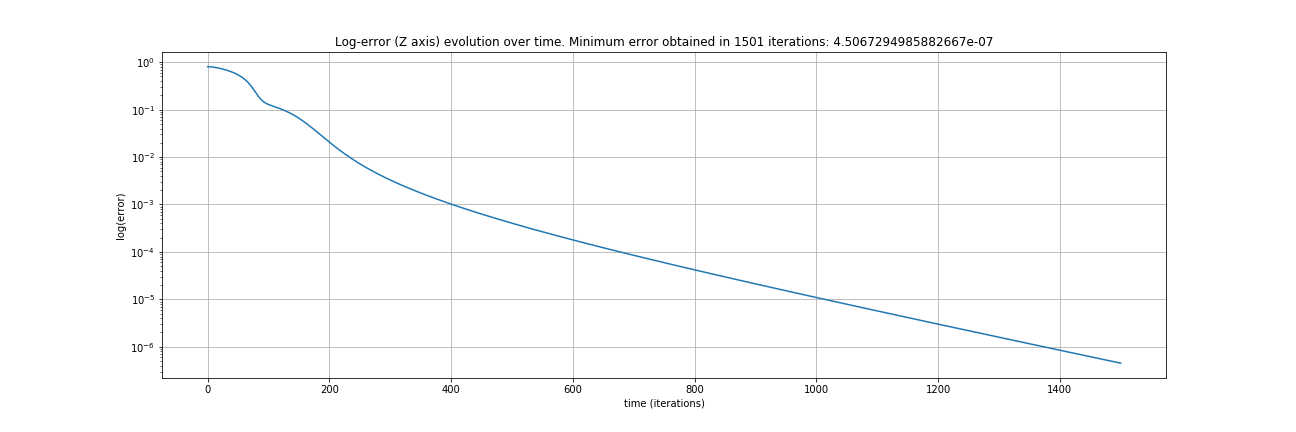

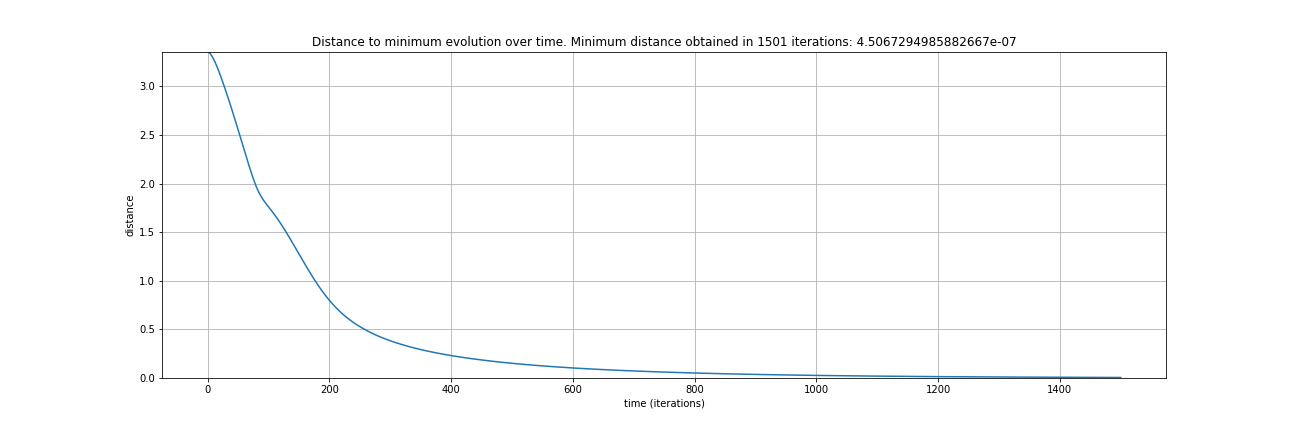

In [19]:
plot_evolution_charts(cost_f, errors_nesterov, distance_nesterov, xs_nesterov, ys_nesterov)

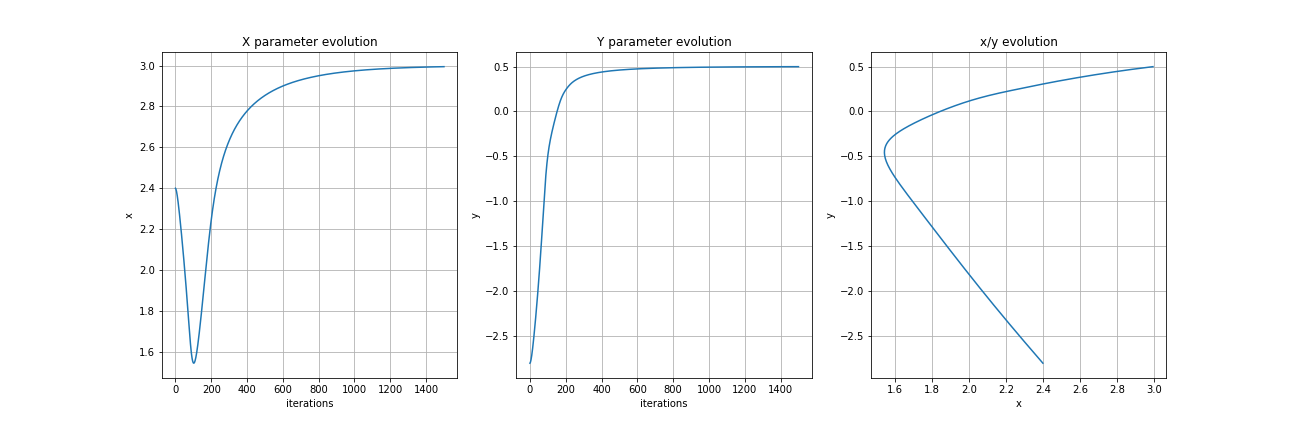

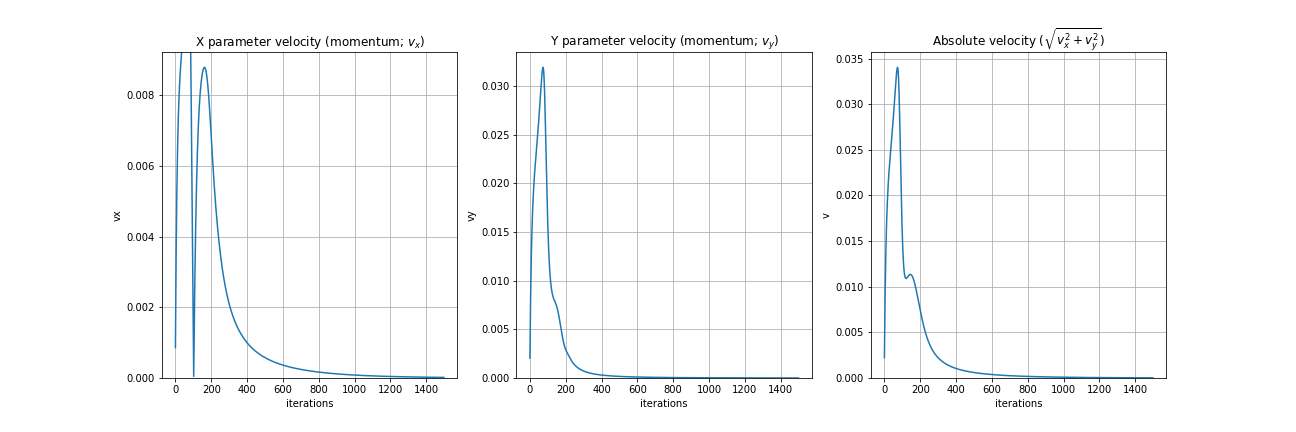

In [20]:
plot_cinematics_charts(xs_nesterov, ys_nesterov)

### AdaGrad

##### AdaGrad (Adaptive Gradient) is a method considered by the author as a subgradient method which attempts to incorporate knowledge of the geometry of the data observed in previous iterations in order to perform informative gradient based learning. Its basic idea is to adapt the learning rates to each parameter so that low frequent occurring features (sparse) have high learning rates and high frequently occurring features (dense) have low learning rates. For this purpose, the algorithm divides each gradient components by the $L_2$ norm of the value of the components of the previous gradients..

$$\mathbf{w_{t+1}} = \mathbf{w_t} - \displaystyle\frac{\eta}{\sqrt{\displaystyle\sum_{T=1}^{t} \mathbf{g_T}^2+\epsilon}} \cdot \mathbf{g}_t$$
Where $\mathbf{g_t}$ represents the gradient of the current iteration, $\eta$ represents the stepsize, $t$ the iteration step and $\epsilon$ the fuze factor which usually has a value of $10^-8$.

In [21]:
class AdaGrad(Optimizer):
    def __init__(self, cost_f, lr=0.001, x=None, y=None):
        super().__init__(cost_f=cost_f, lr=lr, x=x, y=y)
        self.sumsq_dx = 0
        self.sumsq_dy = 0
        
    def step(self, lr = None):
        epsilon = 1e-8
        if not lr:
            lr = self.lr
        # derivative
        f = self.cost_f.eval(self.x, self.y)
        dx = self.cost_f.df_dx(self.x, self.y)
        dy = self.cost_f.df_dy(self.x, self.y)
        self.sumsq_dx += dx**2
        self.sumsq_dy += dy**2
        self.x = self.x - (lr/(np.sqrt(epsilon + self.sumsq_dx)))*dx
        self.y = self.y - (lr/(np.sqrt(epsilon + self.sumsq_dy)))*dy
        
        return [self.x, self.y]

In [22]:
opt=AdaGrad(cost_f=cost_f, lr=learning_rate)

In [23]:
errors_adagrad, distance_adagrad, xs_adagrad, ys_adagrad = run_optimizer(opt=opt, cost_f=cost_f, iterations=iterations)

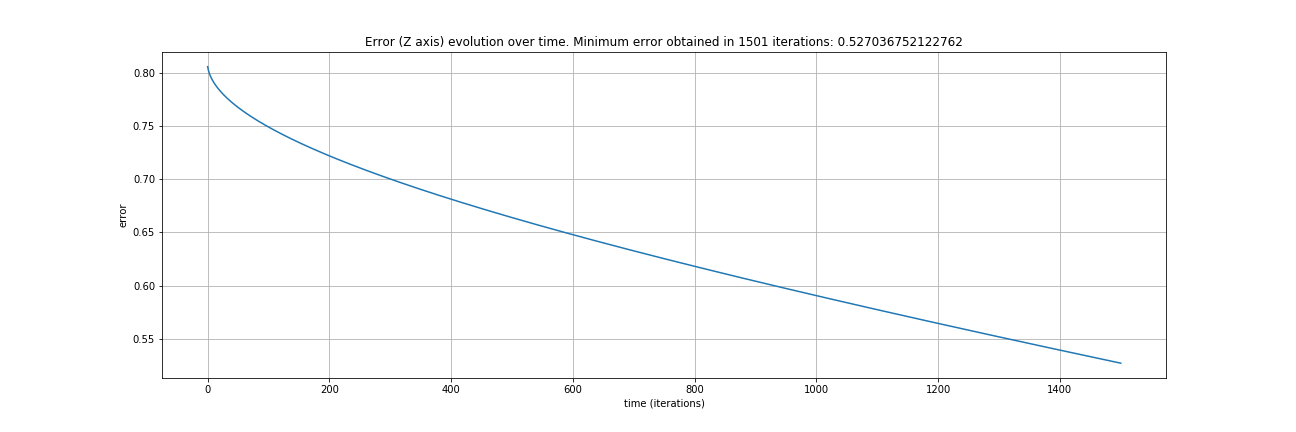

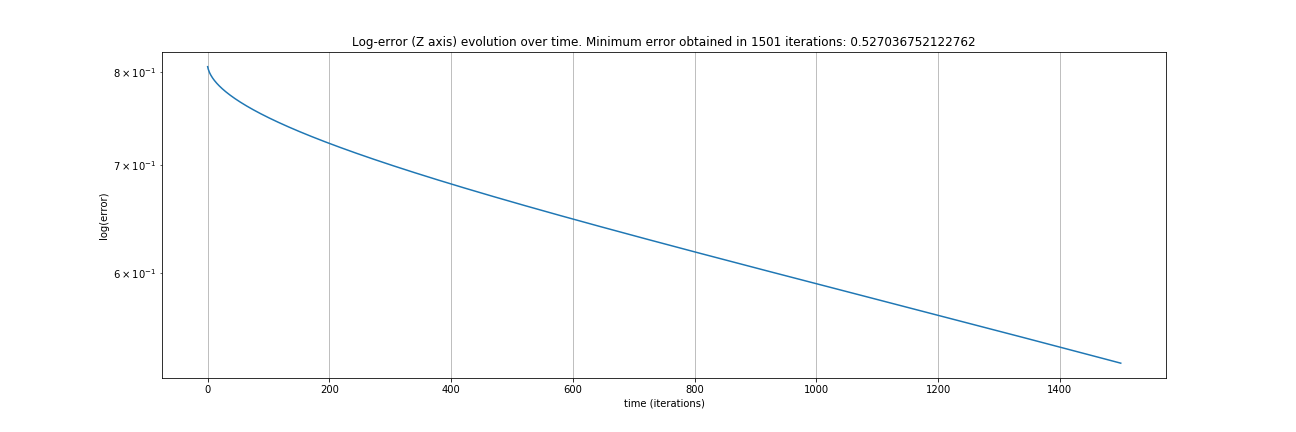

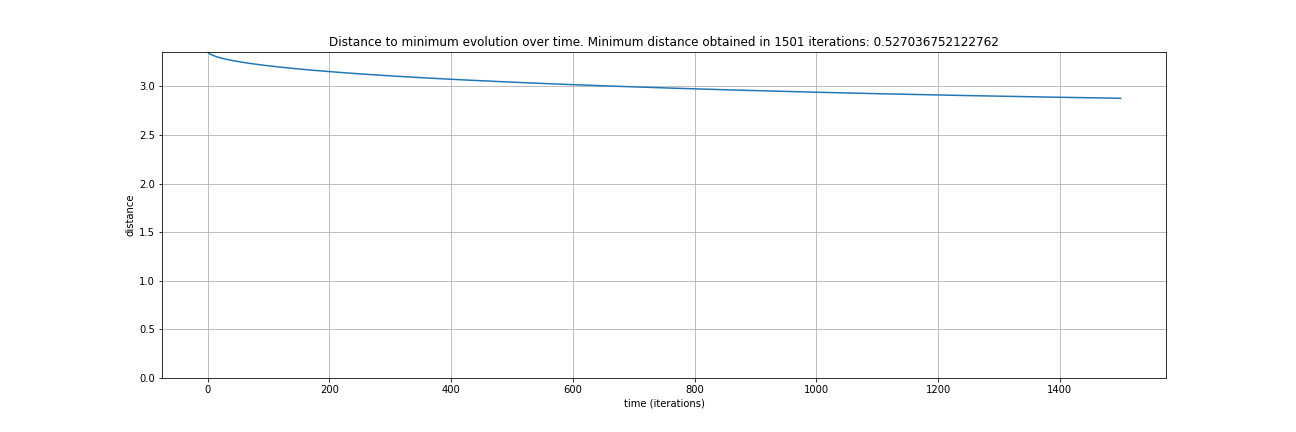

In [24]:
plot_evolution_charts(cost_f, errors_adagrad, distance_adagrad, xs_adagrad, ys_adagrad)

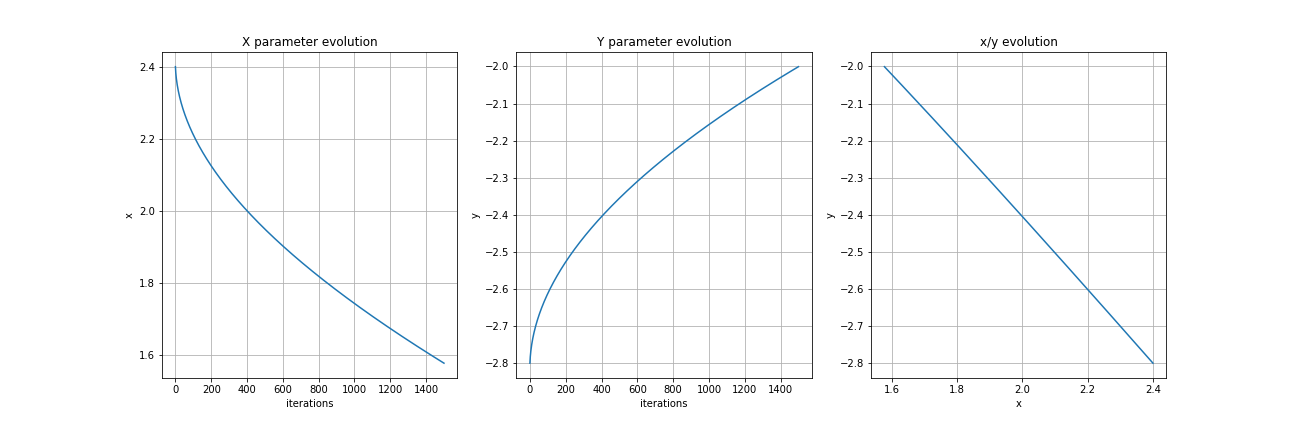

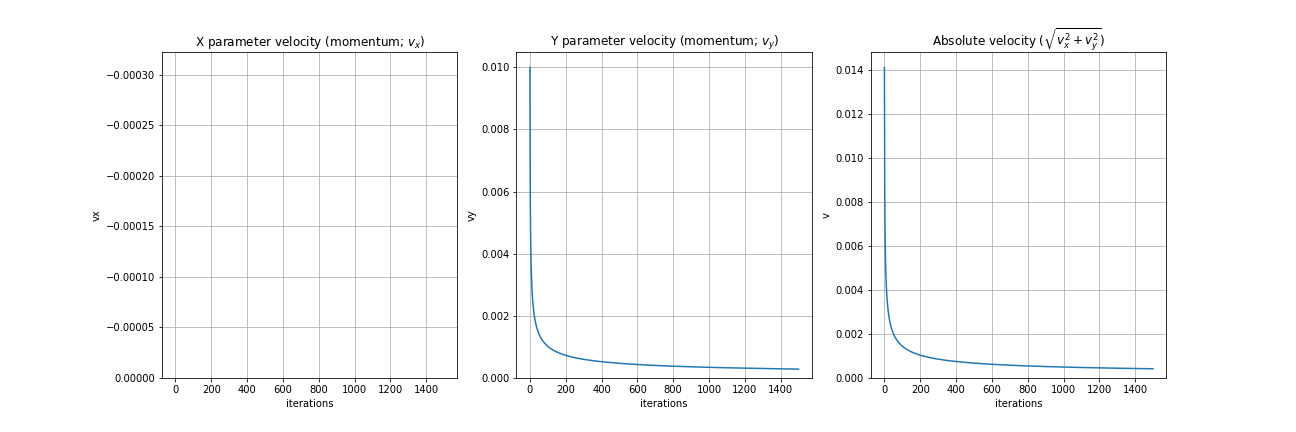

In [25]:
plot_cinematics_charts(xs_adagrad, ys_adagrad)